In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, RidgeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor, StackingRegressor, StackingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import make_scorer
from sklearn.base import RegressorMixin, ClassifierMixin, BaseEstimator
from sklearn.ensemble import VotingClassifier

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor


### Data Collection

In [2]:
import requests

# URLs of the files
train_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module6/exercise/module6_exercise_train.csv'
test_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module6/exercise/module6_exercise_test.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(train_data_url, 'module6_exercise_train.csv')
download_file(test_data_url, 'module6_exercise_test.csv')

Downloaded module6_exercise_train.csv from https://www.raphaelcousin.com/modules/data-science-practice/module6/exercise/module6_exercise_train.csv
Downloaded module6_exercise_test.csv from https://www.raphaelcousin.com/modules/data-science-practice/module6/exercise/module6_exercise_test.csv


In [ ]:
data_train = pd.read_csv('module6_exercise_train.csv', index_col='index')
data_test = pd.read_csv('module6_exercise_test.csv', index_col='index')

### Data Analysis

In [3]:
data_train

NameError: name 'data_train' is not defined

In [ ]:
data_test

In [ ]:
data_train.describe()

In [ ]:
data_train.isnull().sum()

In [ ]:
data_test.isnull().sum()

In [ ]:
# Plot the distribution using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data_train['end_of_day_return'], bins=50, kde=True)
plt.title('Distribution of End of Day Return')
plt.xlabel('End of Day Return')
plt.ylabel('Frequency')
plt.show()

### Model Building and Evaluate

In [ ]:
y = data_train.pop('end_of_day_return')
X = data_train.copy()

In [ ]:
def weighted_accuracy(y_true, y_pred):
    weights = np.abs(y_true)

    # Compute the sign of true and predicted values
    sign_true = np.sign(y_true)
    sign_pred = np.sign(y_pred)

    # Correct predictions where the sign of the true and predicted values match
    correct_predictions = sign_true == sign_pred

    # Compute the weighted accuracy
    weighted_acc = np.sum(weights * correct_predictions) / np.sum(weights)

    return weighted_acc

In [4]:
# Function to plot the evaluation results
def plot_results(mse_train, mse_test, w_acc_train, w_acc_test):
    plt.figure(figsize=(12, 6))

    # MSE plot
    plt.subplot(1, 2, 1)
    plt.plot(mse_train, label="Train MSE", marker='o')
    plt.plot(mse_test, label="Test MSE", marker='o')
    plt.fill_between(range(len(mse_train)), np.min(mse_train), np.max(mse_train), color='blue', alpha=0.1)
    plt.fill_between(range(len(mse_test)), np.min(mse_test), np.max(mse_test), color='orange', alpha=0.1)
    plt.title("MSE over Folds")
    plt.xlabel("Fold")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)

    # weighted_accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(w_acc_train, label="Train weighted_accuracy", marker='o')
    plt.plot(w_acc_test, label="Test weighted_accuracy", marker='o')
    plt.fill_between(range(len(w_acc_train)), np.min(w_acc_train), np.max(w_acc_train), color='blue', alpha=0.1)
    plt.fill_between(range(len(w_acc_test)), np.min(w_acc_test), np.max(w_acc_test), color='orange', alpha=0.1)
    plt.title("weighted_accuracy over Folds")
    plt.xlabel("Fold")
    plt.ylabel("weighted_accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_multi_model_results(results):
    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))

    # Colors for train and test
    train_color = 'skyblue'
    test_color = 'lightgreen'

    # Plot MSE
    ax1.set_title('Mean Squared Error (MSE) Comparison', fontsize=16)
    ax1.set_ylabel('MSE', fontsize=12)
    ax1.set_xlabel('Models', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot weighted_accuracy
    ax2.set_title('weighted_accuracy Comparison', fontsize=16)
    ax2.set_ylabel('weighted_accuracy', fontsize=12)
    ax2.set_xlabel('Models', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)

    x = np.arange(len(results))
    width = 0.35

    for i, (model_name, scores) in enumerate(results.items()):
        # MSE
        mse_train = scores['mse_train']
        mse_test = scores['mse_test']

        ax1.bar(x[i] - width/2, np.mean(mse_train), width, label='Train' if i == 0 else "",
                color=train_color, alpha=0.7)
        ax1.bar(x[i] + width/2, np.mean(mse_test), width, label='Test' if i == 0 else "",
                color=test_color, alpha=0.7)

        ax1.errorbar(x[i] - width/2, np.mean(mse_train),
                     yerr=[[np.mean(mse_train)-np.min(mse_train)], [np.max(mse_train)-np.mean(mse_train)]],
                     fmt='none', ecolor='black', capsize=5)
        ax1.errorbar(x[i] + width/2, np.mean(mse_test),
                     yerr=[[np.mean(mse_test)-np.min(mse_test)], [np.max(mse_test)-np.mean(mse_test)]],
                     fmt='none', ecolor='black', capsize=5)

        # weighted_accuracy
        w_acc_train = scores['w_acc_train']
        w_acc_test = scores['w_acc_test']

        ax2.bar(x[i] - width/2, np.mean(w_acc_train), width, label='Train' if i == 0 else "",
                color=train_color, alpha=0.7)
        ax2.bar(x[i] + width/2, np.mean(w_acc_test), width, label='Test' if i == 0 else "",
                color=test_color, alpha=0.7)

        ax2.errorbar(x[i] - width/2, np.mean(w_acc_train),
                     yerr=[[np.mean(w_acc_train)-np.min(w_acc_train)], [np.max(w_acc_train)-np.mean(w_acc_train)]],
                     fmt='none', ecolor='black', capsize=5)
        ax2.errorbar(x[i] + width/2, np.mean(w_acc_test),
                     yerr=[[np.mean(w_acc_test)-np.min(w_acc_test)], [np.max(w_acc_test)-np.mean(w_acc_test)]],
                     fmt='none', ecolor='black', capsize=5)

    ax1.set_xticks(x)
    ax1.set_xticklabels(results.keys(), rotation=45, ha='right')
    ax2.set_xticks(x)
    ax2.set_xticklabels(results.keys(), rotation=45, ha='right')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

#### Simple Baseline

In [ ]:
# Function to handle train-test evaluation in a fold
def train_and_evaluate(X_train, X_test, y_train, y_test, model):

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on train set
    y_pred_train = model.predict(X_train)
    # Make predictions on train set
    y_pred_test = model.predict(X_test)

    # Compute MSE for train and test
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Compute weighted_accuracy

    w_acc_train = weighted_accuracy(y_train, y_pred_train)
    w_acc_test = weighted_accuracy(y_test, y_pred_test)

    return mse_train, mse_test, w_acc_train, w_acc_test


def run_multi_model_cv(X, y, models, n_splits=5):
    fold = KFold(n_splits=n_splits)
    results = {name: {'mse_train': [], 'mse_test': [], 'w_acc_train': [], 'w_acc_test': []}
               for name in models.keys()}

    for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()

        for name, model in models.items():
            mse_train, mse_test, w_acc_train, w_acc_test = train_and_evaluate(
                X_train, X_test, y_train, y_test, model
            )
            results[name]['mse_train'].append(mse_train)
            results[name]['mse_test'].append(mse_test)
            results[name]['w_acc_train'].append(w_acc_train)
            results[name]['w_acc_test'].append(w_acc_test)
        # Find the model with the best mean w_acc test score
    best_mean_w_acc = -1
    best_model = None
    best_min_w_acc = None
    best_max_w_acc = None

    for name, result in results.items():
        w_acc_test_scores = result['w_acc_test']
        mean_w_acc_test = sum(w_acc_test_scores) / len(w_acc_test_scores)  # Calculate mean w_acc score
        min_w_acc_test = min(w_acc_test_scores)  # Minimum w_acc score
        max_w_acc_test = max(w_acc_test_scores)  # Maximum w_acc score

        if mean_w_acc_test > best_mean_w_acc:
            best_mean_w_acc = mean_w_acc_test
            best_min_w_acc = min_w_acc_test
            best_max_w_acc = max_w_acc_test
            best_model = name

    # Print the best mean w_acc test score, min, max, and the associated model
    print(f"Best mean w_acc test score: {best_mean_w_acc:.4f} by model: {best_model}")
    print(f"Min w_acc test score: {best_min_w_acc:.4f}, Max w_acc test score: {best_max_w_acc:.4f}")
    return results


In [ ]:
# Step 1: Run cross-validation
results = run_multi_model_cv(X, y, {"RandomForestRegressor": RandomForestRegressor(n_jobs=-1)})

Best mean w_acc test score: 0.5196 by model: RandomForestRegressor
Min w_acc test score: 0.5075, Max w_acc test score: 0.5338


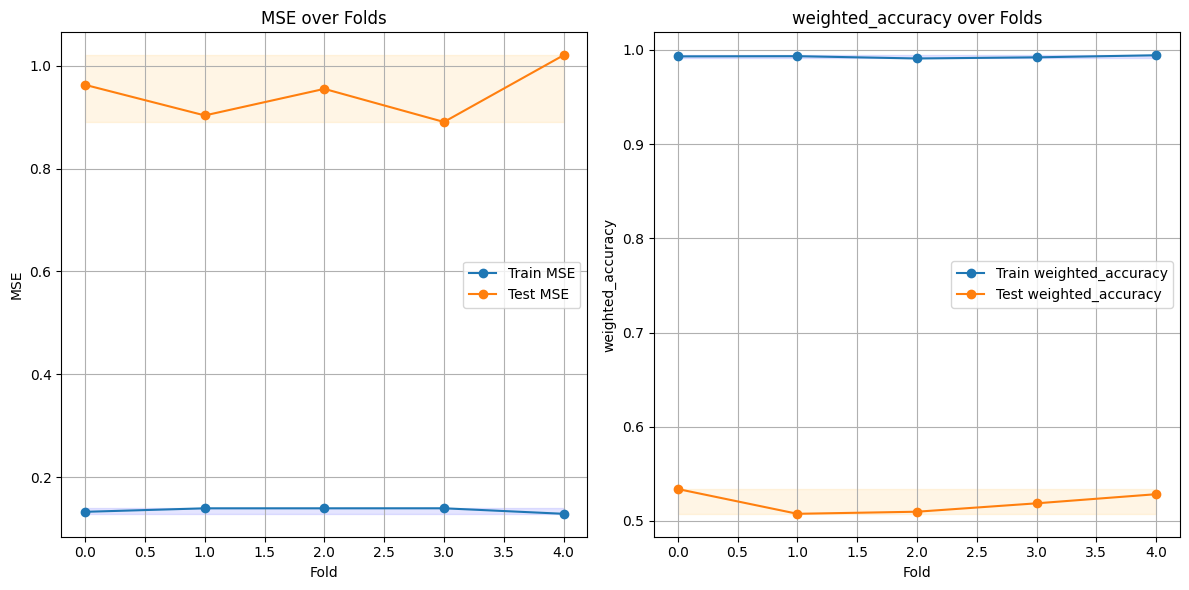

In [ ]:
# Step 2: Plot the results
plot_results(results["RandomForestRegressor"]["mse_train"],
             results["RandomForestRegressor"]["mse_test"],
             results["RandomForestRegressor"]["w_acc_train"],
             results["RandomForestRegressor"]["w_acc_test"])

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Decision Tree Regressor_': DecisionTreeRegressor(),
    'Ridge': Ridge(),
    'Decision Tree Regressor': RandomForestRegressor(n_jobs=-1)
    }

In [ ]:
# Run cross-validation for regression models
results = run_multi_model_cv(X, y, models)

Best mean w_acc test score: 0.5254 by model: Linear Regression
Min w_acc test score: 0.4869, Max w_acc test score: 0.5544


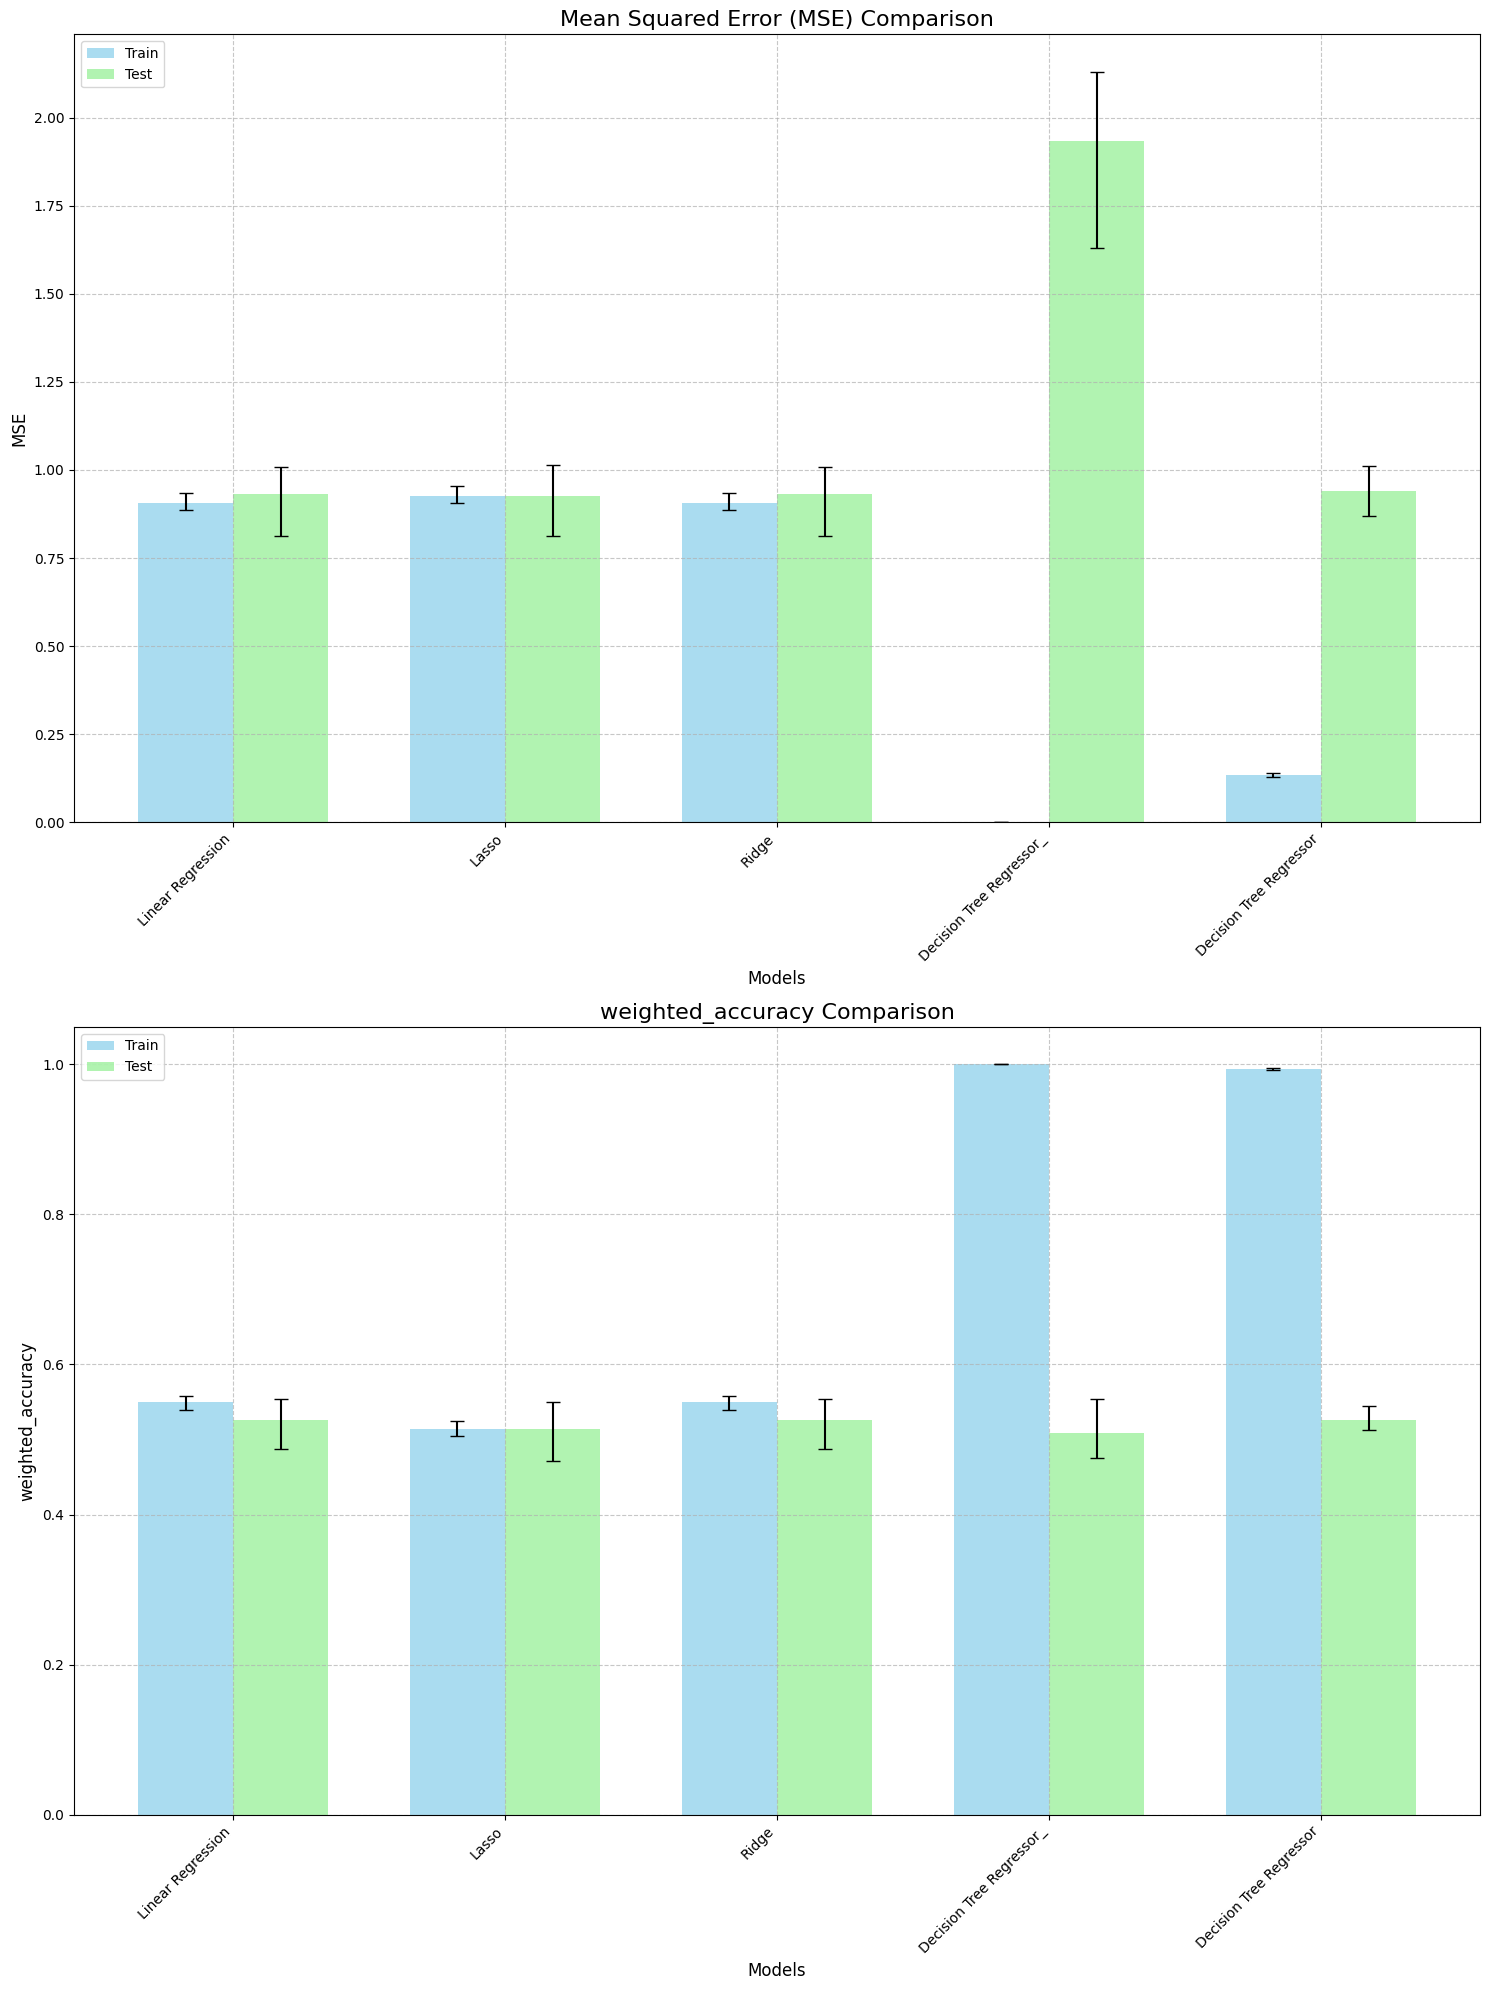

In [ ]:
# Plot MSE results for regression models
plot_multi_model_results(results)

#### Manage properly the objective weighted_accuracy
should we create different classes? custom loss?

Create Compare and Optimize different models

### Submission:

In [10]:
data_train = pd.read_csv('module6_exercise_train.csv', index_col='index')
X_test = pd.read_csv('module6_exercise_test.csv', index_col='index')
y_train = data_train.pop('end_of_day_return')
X_train = data_train.copy()

In [ ]:
wei = [30,50,100, 500, 750, 1000, 1250]
l1_ratio_value = 0.5

try:
    from sklearn.linear_model import ElasticNet
except ImportError:
    class ElasticNet:
        def __init__(self, alpha, l1_ratio):
            self.alpha = alpha
            self.l1_ratio = l1_ratio

elastic_net_models = {}

for w in wei:
    name = f"elasticnet_alpha{w}_l1ratio{l1_ratio_value}"
    elastic_net_models[name] = ElasticNet(alpha=w, l1_ratio=l1_ratio_value)

print("--- Dictionnaire des modèles Elastic Net créés ---")
for k, v in list(elastic_net_models.items()):
    print(k, ":", v)

--- Dictionnaire des modèles Elastic Net créés ---
elasticnet_alpha30_l1ratio0.5 : ElasticNet(alpha=30)
elasticnet_alpha50_l1ratio0.5 : ElasticNet(alpha=50)
elasticnet_alpha100_l1ratio0.5 : ElasticNet(alpha=100)
elasticnet_alpha500_l1ratio0.5 : ElasticNet(alpha=500)
elasticnet_alpha750_l1ratio0.5 : ElasticNet(alpha=750)
elasticnet_alpha1000_l1ratio0.5 : ElasticNet(alpha=1000)
elasticnet_alpha1250_l1ratio0.5 : ElasticNet(alpha=1250)


In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

from scipy.stats import randint as sp_randint, uniform as sp_uniform

try:
    from xgboost import XGBRegressor
except ImportError:
    class XGBRegressor:
        def __init__(self, random_state, n_jobs, objective, tree_method):
            self.random_state = random_state
            self.n_jobs = n_jobs
            self.objective = objective
            self.tree_method = tree_method
        def fit(self, X, y): pass
        def predict(self, X): return np.zeros(len(X))

try:
    pass
except ImportError:
    X = pd.DataFrame(np.random.rand(200, 10))
    y = pd.Series(np.random.rand(200) * 10)
    def weighted_accuracy(y_true, y_pred):
        if np.var(y_true) == 0: return 0.0
        return 1.0 - mean_squared_error(y_true, y_pred) / np.var(y_true)

w_acc_scorer = make_scorer(weighted_accuracy, greater_is_better=True)

xgb_model = XGBRegressor(
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror',
    tree_method='hist'
)

param_distributions = {
    'n_estimators': sp_randint(100, 1000),
    'learning_rate': sp_uniform(0.005, 0.2),
    'max_depth': sp_randint(3, 15),
    'min_child_weight': sp_randint(1, 10),
    'colsample_bytree': sp_uniform(0.5, 0.4),
    'subsample': sp_uniform(0.6, 0.3),
    'reg_alpha': sp_uniform(0.001, 0.2),
    'reg_lambda': sp_uniform(0.001, 0.2)
}

cv_fold = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring=w_acc_scorer,
    cv=cv_fold,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

grid_search.fit(X, y)

best_xgb_model = grid_search.best_estimator_

In [11]:
ridge_results = run_multi_model_cv(X, y, elastic_net_models)


Début de la Cross-Validation (5 folds) pour 6 modèles XGBoost...
  > Fold 1/5
  > Fold 2/5
  > Fold 3/5
  > Fold 4/5
  > Fold 5/5

--- Meilleur Modèle par w_acc Test Moyen ---
Best mean w_acc test score: -0.1130 by model: **elasticnet_alpha10_l1ratio0.5**
Min w_acc test score: -0.2386, Max w_acc test score: -0.0133


In [12]:
best_model = best_xgb_model
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.8208787923016159), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None,
             learning_rate=np.float64(0.019910128735954165), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=443, n_jobs=-1,
             num_parallel_tree=None, ...)

In [13]:

submission = pd.DataFrame({
    'index': X_test.index,
    'end_of_day_return':  best_model.predict(X_test)
})

submission.to_csv('submission.csv', index=False, sep=',')